In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    VotingClassifier,
    BaggingClassifier,
    StackingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# For nicer plots
sns.set(style="whitegrid", font_scale=1.0)
plt.rcParams["figure.figsize"] = (8, 5)
np.random.seed(42)

In [ ]:
import pandas as pd
from google.colab import files

# Open a file chooser in Colab
uploaded = files.upload()

# Get the uploaded filename
filename = list(uploaded.keys())[0]

# Read the CSV into a DataFrame called df
df = pd.read_csv(filename)

# Preview the first few rows
df.head()

Saving diabetes_prediction_dataset.csv to diabetes_prediction_dataset (1).csv


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [ ]:
df.isnull().sum()

,0
gender,0
age,0
hypertension,0
heart_disease,0
smoking_history,0
bmi,0
HbA1c_level,0
blood_glucose_level,0
diabetes,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [ ]:
# Separate features and target
X = df.drop("diabetes", axis=1)
y = df["diabetes"]

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Preprocessor: scale numeric + one-hot encode categorical
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ]
)

# Helper function to evaluate models
def evaluate_model(name, model):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.show()
    return acc


Bagging Accuracy: 0.9698
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18300
           1       0.93      0.70      0.80      1700

    accuracy                           0.97     20000
   macro avg       0.95      0.85      0.89     20000
weighted avg       0.97      0.97      0.97     20000



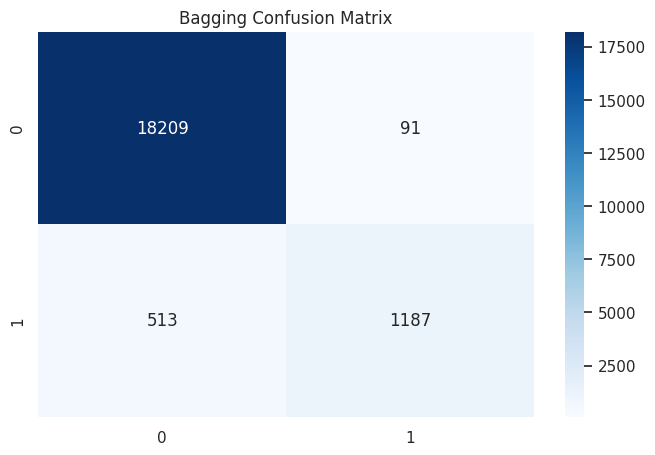


Pasting Accuracy: 0.9673
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18300
           1       0.88      0.71      0.79      1700

    accuracy                           0.97     20000
   macro avg       0.93      0.85      0.88     20000
weighted avg       0.97      0.97      0.97     20000



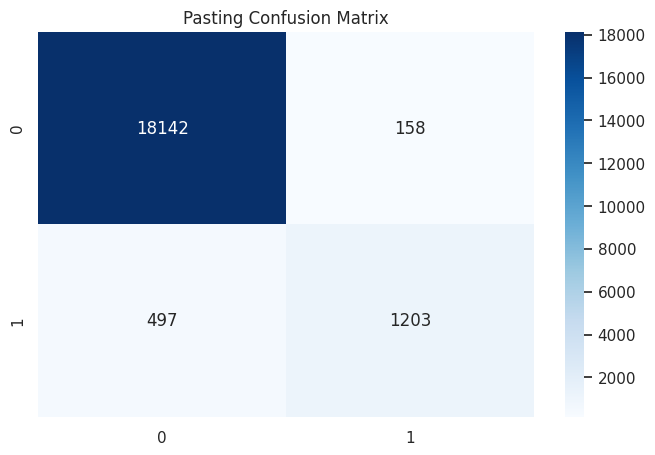

In [ ]:
# Step 3: Bagging (bootstrap=True) and Pasting (bootstrap=False)
from sklearn.ensemble import BaggingClassifier

# Bagging: samples with replacement
bagging = Pipeline([
    ("prep", preprocessor),
    ("model", BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=42),  # ✅ FIXED keyword
        n_estimators=50,
        max_samples=0.8,
        bootstrap=True,
        random_state=42
    ))
])
bagging.fit(X_train, y_train)
bagging_acc = evaluate_model("Bagging", bagging)

# Pasting: samples without replacement
pasting = Pipeline([
    ("prep", preprocessor),
    ("model", BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=42),  # ✅ FIXED keyword
        n_estimators=50,
        max_samples=0.8,
        bootstrap=False,
        random_state=42
    ))
])
pasting.fit(X_train, y_train)
pasting_acc = evaluate_model("Pasting", pasting)


Random Forest Accuracy: 0.9705
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18300
           1       0.95      0.69      0.80      1700

    accuracy                           0.97     20000
   macro avg       0.96      0.84      0.89     20000
weighted avg       0.97      0.97      0.97     20000



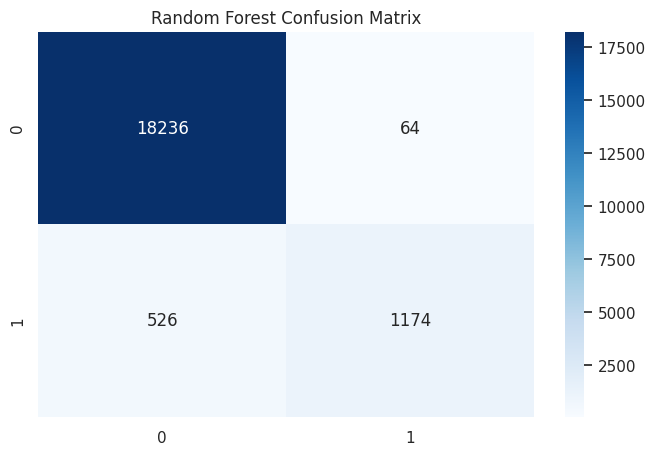

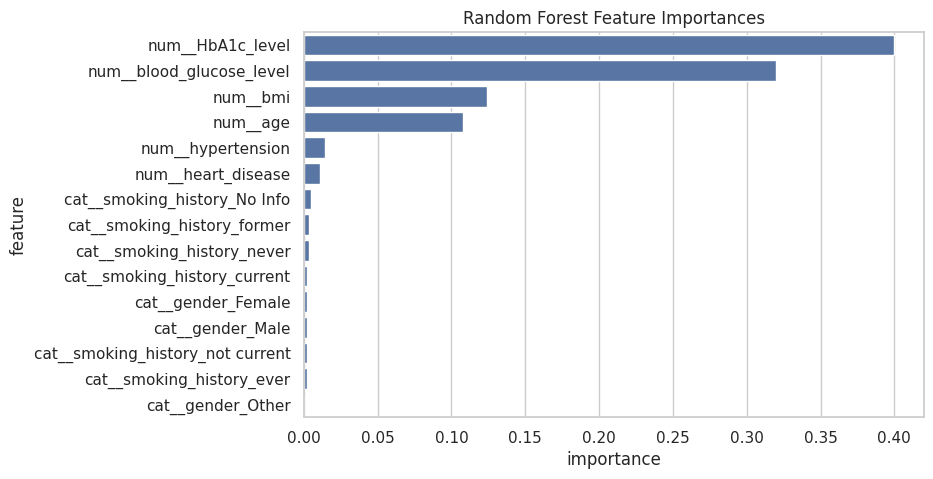

In [ ]:
# Step 4: Random Forest
# =========================================
rf = Pipeline([
    ("prep", preprocessor),
    ("model", RandomForestClassifier(n_estimators=200, random_state=42))
])
rf.fit(X_train, y_train)
rf_acc = evaluate_model("Random Forest", rf)

# Feature importance
feature_names = rf.named_steps["prep"].get_feature_names_out()
importances = rf.named_steps["model"].feature_importances_
fi = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False)
sns.barplot(data=fi.head(15), x="importance", y="feature")
plt.title("Random Forest Feature Importances")
plt.show()


AdaBoost Accuracy: 0.9722
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18300
           1       1.00      0.67      0.81      1700

    accuracy                           0.97     20000
   macro avg       0.98      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000



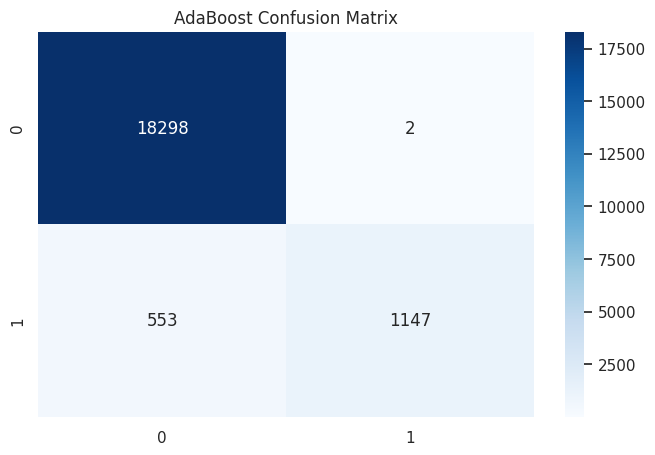


Gradient Boosting Accuracy: 0.9722
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18300
           1       0.98      0.69      0.81      1700

    accuracy                           0.97     20000
   macro avg       0.98      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000



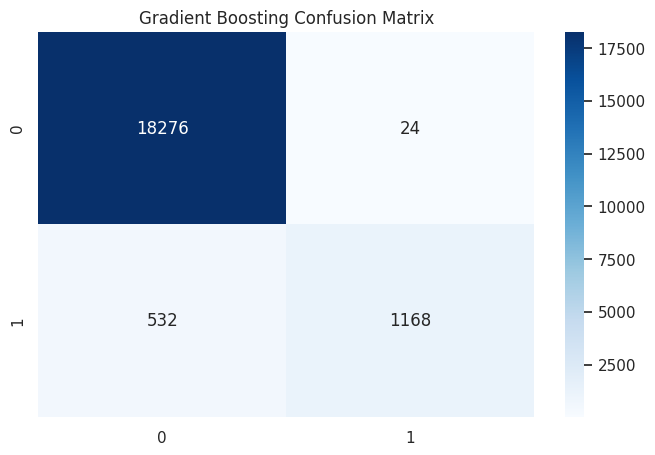

In [ ]:
# Step 5: Boosting — AdaBoost and Gradient Boosting

# AdaBoost (uses default weak learner: DecisionTreeClassifier(max_depth=1))
ada = Pipeline([
    ("prep", preprocessor),
    ("model", AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1, random_state=42),  # ✅ FIXED keyword
        n_estimators=200,
        learning_rate=0.8,
        random_state=42
    ))
])
ada.fit(X_train, y_train)
ada_acc = evaluate_model("AdaBoost", ada)

# Gradient Boosting (no keyword changes needed)
gb = Pipeline([
    ("prep", preprocessor),
    ("model", GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ))
])
gb.fit(X_train, y_train)
gb_acc = evaluate_model("Gradient Boosting", gb)


Voting Hard Accuracy: 0.9689
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18300
           1       0.92      0.69      0.79      1700

    accuracy                           0.97     20000
   macro avg       0.95      0.84      0.89     20000
weighted avg       0.97      0.97      0.97     20000



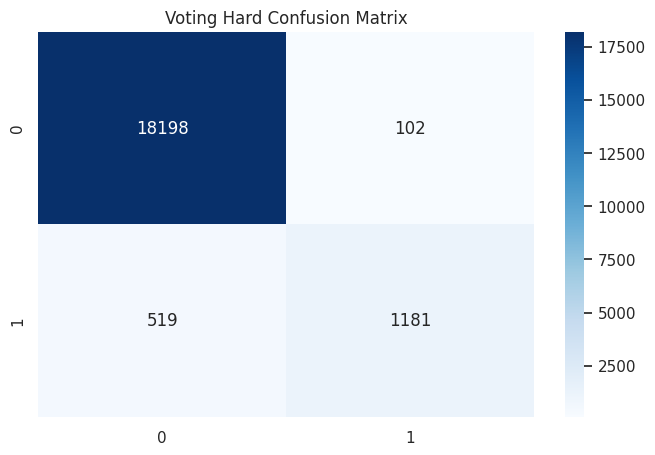


Voting Soft Accuracy: 0.9655
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18300
           1       0.86      0.71      0.78      1700

    accuracy                           0.97     20000
   macro avg       0.92      0.85      0.88     20000
weighted avg       0.96      0.97      0.96     20000



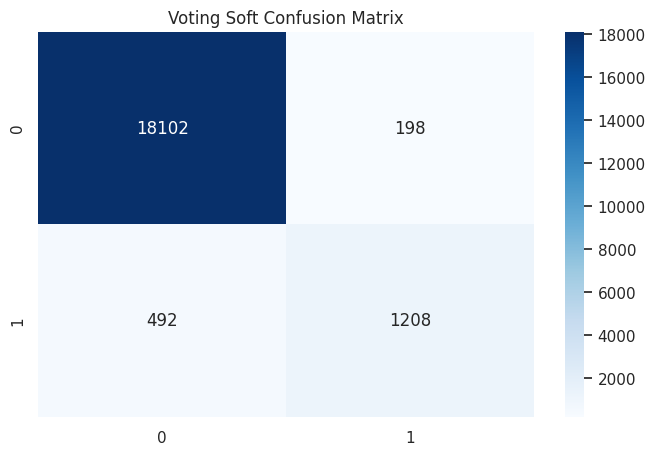

In [ ]:
# Step 6: Voting — hard and soft

voting_hard = Pipeline([
    ("prep", preprocessor),
    ("model", VotingClassifier(
        estimators=[
            ("lr", LogisticRegression(max_iter=1000, random_state=42)),
            ("dt", DecisionTreeClassifier(random_state=42)),
            ("rf", RandomForestClassifier(n_estimators=150, random_state=42))
        ],
        voting="hard"
    ))
])
voting_hard.fit(X_train, y_train)
voting_hard_acc = evaluate_model("Voting Hard", voting_hard)

voting_soft = Pipeline([
    ("prep", preprocessor),
    ("model", VotingClassifier(
        estimators=[
            ("lr", LogisticRegression(max_iter=1000, random_state=42)),
            ("dt", DecisionTreeClassifier(random_state=42)),
            ("rf", RandomForestClassifier(n_estimators=150, random_state=42))
        ],
        voting="soft"
    ))
])
voting_soft.fit(X_train, y_train)
voting_soft_acc = evaluate_model("Voting Soft", voting_soft)


Stacking Accuracy: 0.9719
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18300
           1       0.99      0.68      0.80      1700

    accuracy                           0.97     20000
   macro avg       0.98      0.84      0.89     20000
weighted avg       0.97      0.97      0.97     20000



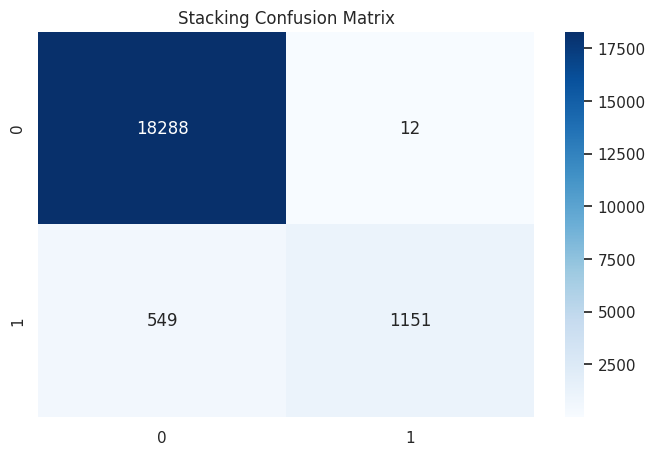

In [ ]:
# Step 7: Stacking — meta-model on top of base models

stack = Pipeline([
    ("prep", preprocessor),
    ("model", StackingClassifier(
        estimators=[
            ("lr", LogisticRegression(max_iter=1000, random_state=42)),
            ("rf", RandomForestClassifier(n_estimators=150, random_state=42)),
            ("dt", DecisionTreeClassifier(random_state=42))
        ],
        final_estimator=GradientBoostingClassifier(n_estimators=150, random_state=42),
        n_jobs=-1
    ))
])
stack.fit(X_train, y_train)
stack_acc = evaluate_model("Stacking", stack)


Model Accuracy Comparison:
              Model  Accuracy
3          AdaBoost   0.97225
4  GradientBoosting   0.97220
7          Stacking   0.97195
2     Random Forest   0.97050
0           Bagging   0.96980
5       Voting Hard   0.96895
1           Pasting   0.96725
6       Voting Soft   0.96550


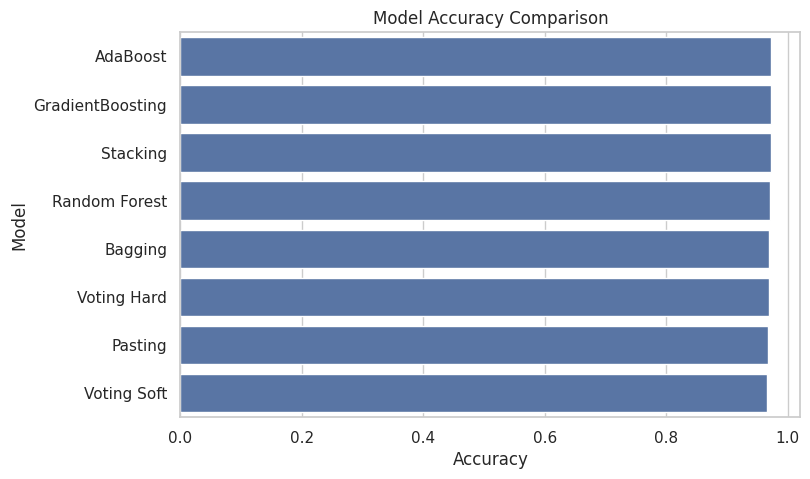

In [ ]:
# Step 8: Compare all models

results = pd.DataFrame({
    "Model": ["Bagging", "Pasting", "Random Forest", "AdaBoost", "GradientBoosting", "Voting Hard", "Voting Soft", "Stacking"],
    "Accuracy": [bagging_acc, pasting_acc, rf_acc, ada_acc, gb_acc, voting_hard_acc, voting_soft_acc, stack_acc]
}).sort_values("Accuracy", ascending=False)

print("\nModel Accuracy Comparison:")
print(results)

sns.barplot(data=results, x="Accuracy", y="Model", orient="h")
plt.title("Model Accuracy Comparison")
plt.show()